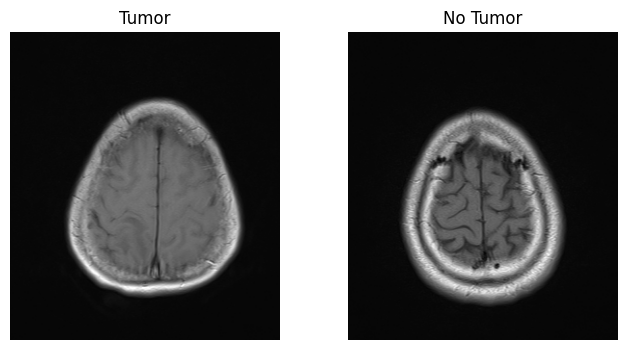

In [174]:
# Load and visualize images from YES and NO folders

import os
import matplotlib.pyplot as plt
import random
import keras
import tensorflow
from PIL import Image
from tensorflow.keras import optimizers,callbacks
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import pandas as pd

yes_dir = "/kaggle/input/tumor-classes/YES/YES"
no_dir = "/kaggle/input/tumor-classes/NO/NO"

# Collect file names
yes_imgs = [f for f in os.listdir(yes_dir) if f.lower().endswith(('.png','.jpg','.jpeg','.bmp'))]
no_imgs = [f for f in os.listdir(no_dir) if f.lower().endswith(('.png','.jpg','.jpeg','.bmp'))]


#Original set has 2:1 bias for YES, so use 'n' to divide YES folder.
n=1
n_factored_yes = random.sample(yes_imgs, len(yes_imgs)//n)
yes_paths = [os.path.join(yes_dir, f) for f in n_factored_yes]
no_paths = [os.path.join(no_dir, f) for f in no_imgs]
all_paths = yes_paths + no_paths
all_labels = ['YES']*len(yes_paths) + ['NO']*len(no_paths)

df = pd.DataFrame({'filename': all_paths, 'class': all_labels})


# FULL set of NO images

#each class
plt.figure(figsize=(8,4))
for i, folder in enumerate([yes_dir, no_dir]):
    img_name = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, img_name)
    img = Image.open(img_path)
    plt.subplot(1,2,i+1)
    plt.imshow(img)
    plt.title("Tumor" if i==0 else "No Tumor")
    plt.axis('off')
plt.show()

In [175]:
import tensorflow as tf

# Map string labels to integers
label_mapping = {'YES': 1, 'NO': 0}


def df_to_dataset(dataframe, batch_size, shuffle=True):
    dataframe = dataframe.copy()
    dataframe['label'] = dataframe['class'].map(label_mapping)

    ds = tf.data.Dataset.from_tensor_slices((dataframe['filename'].values, dataframe['label'].values))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))

    def process_path(file_path, label):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, img_size)  # img_size = (height, width)
        return img, label

    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds



In [88]:
# ARCHITECTURE SECTION
from tensorflow.keras import Sequential,Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, RandomFlip, RandomRotation

# Create the input shape tuple (height, width, channels)
input_shape = configurations["image_size"] + (3,)

model = Sequential([#Reinitializes model
    Input(shape=input_shape),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    # Dropout(0.3),  # slight regularization
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # binary output
])


In [214]:
#HYPERPARAMETERS SECTION
configurations={
    "epochs": 10,
    # "fine_tune_layers": 20,  # Number of top layers to unfreeze during fine-tuning
    "batch_size": 64,        # for mini batch gradient descent
    "learning_rate": 0.00001, # for all layers, you can also set it per layer from create_model function.
    "image_size": (150,150),

    "val_split": 0.15,        # Validation split ratio
    # "dropout_rate": 0.4,      # Dropout rate for classifier layers
    "l2_reg": 10*1e-5,          # L2 regularization strength for each layer, or you can individually set it per layer from create_model function.

    "use_augmentation": True, # switch for data augmentation enabling. 
    #Change augmentation settings below in data_aug layer.
    #U can switch augmentation on/off mid training too with this.

    "Training Control": False,  # switch for training control callbacks enabling. simple application of early stopping, learning rate reduction and model checkpointing.
    "early_stopping_patience": 10,   # Epochs to wait before early stopping
    "lr_reduction_patience": 2,     # Epochs to wait before reducing LR
    "lr_reduction_factor": 0.5,     # Factor to reduce LR by
    "min_lr": 1e-8,                 # Minimum learning rate
}
  # Change to (224, 224) or any size you want. 256^2 is minimum for accurate prognosis 
#of very small lesions/tumors aswell.
batch_size = configurations["batch_size"]
img_size = configurations["image_size"]

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_df, val_df = train_test_split(
    df,
    test_size=configurations["val_split"],
    stratify=df['class'],  # ensures class balance in both sets
    random_state=42        # reproducibility
)

# Optional: Reset index for cleanliness
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
train_df = df_to_dataset(train_df, batch_size=batch_size, shuffle=True)

val_df = df_to_dataset(val_df, batch_size=batch_size, shuffle=False)

# val_datagen=ImageDataGenerator(rescale=1./255)
# train_datagen=val_datagen

# train_gen = train_datagen.flow_from_dataframe(
#     train_df,
#     x_col='filename',
#     y_col='class',
#     class_mode='binary',
#     target_size=img_size,
#     batch_size=batch_size,
#     shuffle=True
# )

# val_gen = val_datagen.flow_from_dataframe(
#     val_df,
#     x_col='filename',
#     y_col='class',
#     class_mode='binary',
#     target_size=img_size,
#     batch_size=batch_size,
#     shuffle=False
# )

callbacks_list=[]
if configurations['Training Control']==True:
  checkpoint_file = 'best_model.keras'
  callbacks_list.extend([
          callbacks.EarlyStopping(
              monitor='val_accuracy',
              patience=configurations["early_stopping_patience"],
              restore_best_weights=True,
              min_delta=0.001,
              verbose=1
          ),
          callbacks.ReduceLROnPlateau(
              monitor='val_loss',
              factor=configurations["lr_reduction_factor"],
              patience=configurations["lr_reduction_patience"],
              min_lr=configurations["min_lr"],
              verbose=1
          ),
          callbacks.ModelCheckpoint(
              checkpoint_file,
              monitor='val_accuracy',
              save_best_only=True,
              mode='max',
              verbose=1)])

In [209]:
from tensorflow.keras import layers
Loaded_model = tensorflow.keras.models.load_model('/kaggle/input/csot_sub.keras/keras/default/1/CSOT_sub.keras')

data_aug=tensorflow.keras.Sequential([
layers.Rescaling(1./255),                # Rescale pixel values to [0,1]
layers.RandomRotation(0.05),             
layers.RandomTranslation(0.03, 0.03), 
layers.RandomZoom(0.05)

],name='my_data_aug')

inputs = tensorflow.keras.Input(shape=(img_size[0], img_size[1], 3))  
if configurations["use_augmentation"]==True:
    x=data_aug(inputs)
else:
    x=inputs
    
x = Loaded_model(x)                    # pass augmented images through your model
model = tensorflow.keras.Model(inputs=inputs, outputs=x)


In [235]:
from tensorflow.keras import optimizers
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


Loaded_model.compile(optimizer=optimizers.Adam(configurations['learning_rate']),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = Loaded_model.fit(
    train_df,
    validation_data=val_df,
    batch_size=batch_size,
    epochs=configurations["epochs"],
    callbacks=callbacks_list
)

SyntaxError: invalid syntax (1456831157.py, line 14)

Using last Conv2D layer: conv2d_52
Predicted sigmoid probability: 0.0435


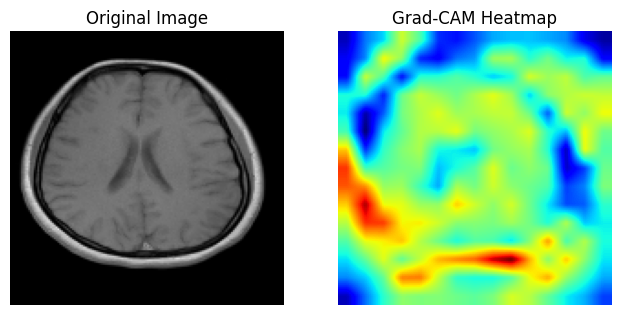

In [255]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import Input, Model
import tensorflow.keras.backend as K

# User configuration
MODEL_PATH = '/kaggle/input/csot-sub-keras/CSOT_sub.keras'
IMAGE_PATH = '/kaggle/input/tumor-classes/NO/NO/43335432.jpg'
IMG_SIZE = (150, 150)

# Load your model
loaded_model = tf.keras.models.load_model(MODEL_PATH)

# Build all nested models recursively to define graph
def build_all_models_recursive(model, input_shape):
    if isinstance(model, (tf.keras.Sequential, tf.keras.Model)):
        try:
            dummy_input = tf.random.uniform((1,) + input_shape)
            model(dummy_input)
        except Exception:
            pass
        for layer in getattr(model, 'layers', []):
            if isinstance(layer, (tf.keras.Sequential, tf.keras.Model)):
                build_all_models_recursive(layer, input_shape)

build_all_models_recursive(loaded_model, (IMG_SIZE[0], IMG_SIZE[1], 3))

# Find last Conv2D layer name recursively
def find_last_conv_layer_name(model):
    for layer in reversed(getattr(model, 'layers', [])):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
        if isinstance(layer, (tf.keras.Sequential, tf.keras.Model)):
            found = find_last_conv_layer_name(layer)
            if found:
                return found
    return None

last_conv_layer_name = find_last_conv_layer_name(loaded_model)
if last_conv_layer_name is None:
    raise ValueError("No Conv2D layer found in the model.")
print(f"Using last Conv2D layer: {last_conv_layer_name}")

# Get last conv layer index inside loaded_model.layers to know when to output
def find_last_conv_layer_index(model, layer_name):
    for idx, layer in enumerate(model.layers):
        if layer.name == layer_name:
            return idx
    raise ValueError("Could not find layer by name.")

last_conv_idx = find_last_conv_layer_index(loaded_model, last_conv_layer_name)

# Build functional input
input_tensor = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Pass the input tensor through all layers in order, capturing last conv layer output
x = input_tensor
last_conv_output = None
for i, layer in enumerate(loaded_model.layers):
    x = layer(x)
    if i == last_conv_idx:
        last_conv_output = x

# x is final output now
cam_model = Model(inputs=input_tensor, outputs=[last_conv_output, x])

# Image preprocessing
def preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0  # Adjust normalization if needed
    img_batch = tf.expand_dims(img, axis=0)
    return img, img_batch

# Grad-CAM heatmap generation
def make_gradcam_heatmap(img_batch, model):
    with tf.GradientTape() as tape:
        tape.watch(img_batch)
        conv_outputs, predictions = model(img_batch, training=False)
        loss = predictions[:, 0]  # Modify if multi-class
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs[0], axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + K.epsilon())
    return heatmap.numpy()

# V
def display_heatmap_on_image(img_tensor, heatmap, img_size):
    # Convert float normalized image [0,1] to uint8 [0,255] for display
    if img_tensor.dtype in [tf.float32, np.float32]:
        img_show = np.clip(img_tensor.numpy() * 255, 0, 255).astype('uint8')
    else:
        img_show = img_tensor.numpy().astype('uint8')

    # Resize heatmap to match image size (width, height)
    heatmap_resized = cv2.resize(heatmap, (img_size[1], img_size[0]))

    # Scale heatmap to 0-255 and convert to uint8
    heatmap_uint8 = np.uint8(255 * heatmap_resized)

    # Apply JET colormap to heatmap (produces BGR image)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

    # Convert BGR heatmap to RGB for matplotlib plotting
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # Blend original image and heatmap with alpha for overlay
    superimposed_img = cv2.addWeighted(img_show, 0.6, heatmap_color, 0.4, 0)

    # Plot original image, heatmap, and overlay
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.axis('off')
    plt.imshow(img_show)

    plt.subplot(1, 3, 2)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')
    plt.imshow(heatmap_resized, cmap='jet')

    # plt.subplot(1, 3, 3)
    # plt.title('Overlay')
    # plt.axis('off')
    # plt.imshow(superimposed_img)

    plt.show()


import tensorflow as tf

def predict_on_image_path(loaded_model, image_path, img_size):
    # Load and preprocess the image
    img_raw = tf.io.read_file(image_path)
    img = tf.image.decode_image(img_raw, channels=3, expand_animations=False)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0,1] if your model expects that
    img_batch = tf.expand_dims(img, axis=0)  # Add batch dimension

    # Predict using the loaded model
    prediction = loaded_model(img_batch, training=False)
    # If output is sigmoid (binary classification), prediction shape is (1,1)
    prob = prediction.numpy()[0, 0]

    return prob


probability = predict_on_image_path(loaded_model, IMAGE_PATH, (150,150))
print(f"Predicted sigmoid probability: {probability:.4f}")



img_raw, img_array = preprocess_image(IMAGE_PATH)
heatmap = make_gradcam_heatmap(img_array, cam_model)
display_heatmap_on_image(img_raw, heatmap,img_size)


In [221]:
print(loaded_model.summary())

Model: "functional_614"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_44 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_14 (Sequential)      │ (None, 1)              │     1,057,665 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,057,665 (4.03 MB)

 Trainable params: 1,056,961 (4.03 MB)

 Non-trainable params: 704 (2.75 KB)

None


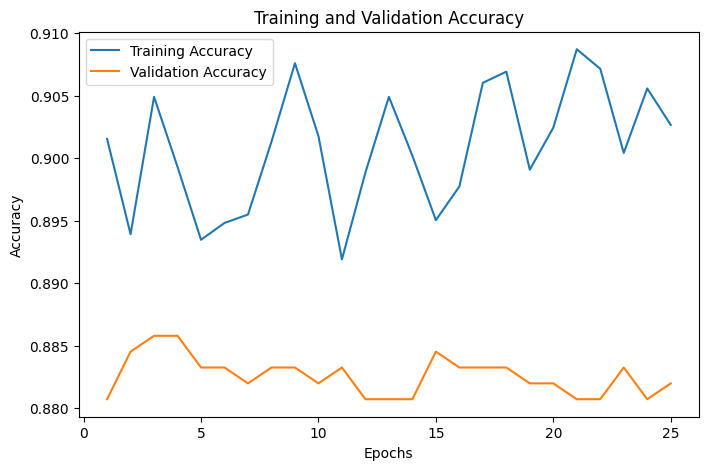

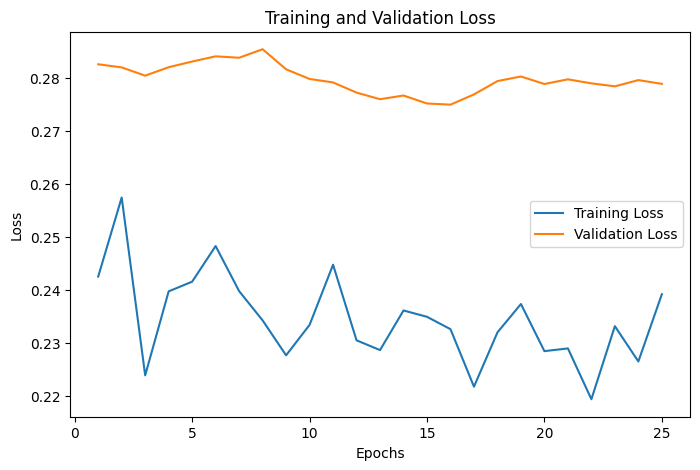

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
True Labels (Numerical):
[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Predicted Probabilities (Sigmoid Output - Truncated to 2 Decimals):
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [169]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, len(acc) + 1)
#ACCURACY PLOTTING
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
#LOSS PLOTTING
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Get a batch and select 10 samples
sample_batch = next(val_gen)
sample_images = sample_batch[0][:10]
sample_true_labels = sample_batch[1][:10]
predictions = model.predict(sample_images)
truncated_predictions = [round(p, 2) for p in predictions.flatten().tolist()]
print("True Labels (Numerical):")
print(sample_true_labels.tolist())
print("\nPredicted Probabilities (Sigmoid Output - Truncated to 2 Decimals):")
print(truncated_predictions)


In [184]:
print("Model Summary:")
model.summary()


Model Summary:


Model: "functional_531"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_39 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_data_aug (Sequential)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_14 (Sequential)      │ (None, 1)              │     1,057,665 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,057,665 (4.03 MB)

 Trainable params: 1,056,961 (4.03 MB)

 Non-trainable params: 704 (2.75 KB)